In [ ]:
import torch 
import torchvision
import numpy as np

from PIL import Image
import os
import matplotlib.pyplot as plt

def pil_loader(path: str) -> Image.Image:
    # from pytorch https://pytorch.org/vision/stable/_modules/torchvision/datasets/folder.html
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')



class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_paths,transform=None):
      #' Initialization'
      self.image_path=data_paths
      
      self.transform = transform

      self.width=255
      self.height=255
   
    def __len__(self):
      'Denotes the total number of samples'
      return len(self.image_path)
      
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        path = self.image_path[index]
        # Load data and get label
        
        X =  np.array(pil_loader(path))
       
        if self.transform:
            X = self.transform(X)
        return  X

    def show(self,index):
      plt.figure(figsize=(10,10))
      plt.imshow(self[index].permute(1,2,0).numpy())
      plt.show()

In [13]:
def print_only_arguments(encoder,pretrained_settings,**params):
    print(encoder,pretrained_settings)
    print(params)
    
    
    
print_only_arguments(**{
        "encoder": "a",
        "pretrained_settings": "b",
        "params": {
            "out_channels": (64, 128, 256, 512, 512, 512),
            "config": "c",
            "batch_norm": False,
}})

a b
{'params': {'out_channels': (64, 128, 256, 512, 512, 512), 'config': 'c', 'batch_norm': False}}


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# building auotoencoder
based on : https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html for the pytorch details <br />
For the autoencoder model, I used a model inspired by : https://blog.keras.io/building-autoencoders-in-keras.html (convolutional encoders) <br />


In [ ]:
import torch.nn as nn

class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image.
             - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, base_channel, kernel_size=3, padding=1, stride=2), 
            act_fn(),
            nn.Conv2d(base_channel, base_channel, kernel_size=3, padding=1,stride=2),
            act_fn(),
            nn.Conv2d(base_channel, base_channel*2, kernel_size=3, padding=1,stride=2),
            act_fn(),
            nn.Conv2d(base_channel*2, base_channel*2, kernel_size=3, padding=1,stride=2),
            act_fn(),
            nn.Conv2d(base_channel*2, base_channel*2, kernel_size=3, padding=1,stride=2),
            act_fn(),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channel : int,
                 base_channel,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channel : Number of channels of the image to reconstruct
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(base_channel*2, base_channel*2, kernel_size=3, output_padding=1, padding=1, stride=2), # inverse of conv2d 
            act_fn(),
            nn.ConvTranspose2d(base_channel*2, base_channel*2, kernel_size=3, output_padding=1, padding=1, stride=2), # inverse of conv2d 
            act_fn(),
            nn.ConvTranspose2d(base_channel*2, base_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # inverse of conv2d 
            act_fn(),
            nn.ConvTranspose2d(base_channel, base_channel, kernel_size=3, output_padding=1, padding=1, stride=2), # inverse of conv2d 
            act_fn(),

            nn.ConvTranspose2d(base_channel, num_input_channel, kernel_size=3, output_padding=1, padding=1, stride=2), #
            nn.Sigmoid()# The input images is between 0 and 1
            
            
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [ ]:
#!pip install pytorch-lightning>=1.4

In [ ]:
import pytorch_lightning as pl

class Autoencoder(pl.LightningModule):

    def __init__(self,
                 intermediate_channel_size: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 256,
                 height: int = 256):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels,intermediate_channel_size)
        self.decoder = decoder_class(num_input_channels,intermediate_channel_size)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x_hat = self.forward(batch)# there is no label
        loss = torch.nn.functional.mse_loss(batch, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        return {"optimizer": optimizer, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss



In [ ]:
from pytorch_lightning import Trainer
latent_dim=128
model = Autoencoder(intermediate_channel_size=32)   
trainer = Trainer( gpus=1 if str(device).startswith("cuda") else 0,max_epochs=2)
trainer.fit(model, dataloader)#200 k --> 4k parameters

In [ ]:
torch.save(model.state_dict(), "model_autoencoding.pth")

# load previous model

In [ ]:
model_saved=Autoencoder(intermediate_channel_size=32)
model_saved.load_state_dict(torch.load("model_autoencoding.pth"))

# analysis

In [ ]:
from tqdm import tqdm
def comparaison_images_and_reconstruction(model,batch,predictions,number_to_plot=4):
    """
    take a batch of images as input
    show the original and reconstructed image

    
    """
    list_image=[batch.numpy()[i,:,:,:].transpose(1,2,0) for i in range(number_to_plot)]
    list_prediction=[predictions.numpy()[i,:,:,:].transpose(1,2,0) for i in range(number_to_plot)]
    image_reconstruct=np.concatenate(list_prediction)
    image=np.concatenate(list_image)

    black_separation=np.zeros((image.shape[0],20,3))
    abs_diff=np.abs(image-image_reconstruct) 
    if np.all(image==image_reconstruct):
        to_plot=np.concatenate([image,black_separation,image_reconstruct,black_separation,abs_diff],axis=1)
    else:
        abs_diff_normalize=(abs_diff-abs_diff.min())/(abs_diff.max()-abs_diff.min())
        to_plot=np.concatenate([image,black_separation,image_reconstruct,black_separation,abs_diff,black_separation,abs_diff_normalize],axis=1)

    
    
    plt.figure(figsize=(20,10))
    plt.imshow(to_plot)
    plt.show()

batch=next(iter(dataloader))
model_saved.eval()
with torch.no_grad():
    predictions=model_saved(batch)
batch_size=predictions.shape[0]
comparaison_images_and_reconstruction(model_saved,batch,predictions,number_to_plot=6)
batch_test=next(iter(dataloader_test))
model_saved.eval()
with torch.no_grad():
    predictions=model_saved(batch_test)

comparaison_images_and_reconstruction(model_saved,batch_test,predictions,number_to_plot=6)

# clustering of the representations

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)

    #because the dataset is too large, doing the computation directly lead to an out of memory error on cpu
    imgs=torch.cat(img_list, dim=0)
    del img_list

    embedings=torch.cat(embed_list, dim=0)
    del embed_list
    return (imgs, embedings)

#train_img_embeds = embed_imgs(model, dataloader)
test_img_embeds = embed_imgs(model_saved, dataloader_test)

In [ ]:
mean_embeding=test_img_embeds[1].mean(dim=(2,3))

In [1]:
def find_similar_images(all_imgs, all_img_emb,i, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    img=all_imgs[i]
    emb=all_img_emb[i]
    
    dist = torch.cdist(emb[None,:], all_img_emb, p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    
    imgs_to_display = torch.cat([img[None], all_imgs[indices[1:K+1]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=False, range=(-1,1))#is the range correct?
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(8):
    find_similar_images(test_img_embeds[0],test_img_embeds[1].flatten(1,-1),i)

NameError: name 'test_img_embeds' is not defined

In [14]:
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y %Hh %Mm %Ss")
"tensorboard/"+dt_string
NUM_IMGS = 1000#len(train_dataset)


with SummaryWriter("tensorboard_"+str(NUM_IMGS)) as writer:

    
    embeding_flatten=test_img_embeds[1].flatten(1,-1)[0:NUM_IMGS]#
    img_to_save=test_img_embeds[0][0:NUM_IMGS]#keep torch tensor
    writer.add_embedding(embeding_flatten, # Encodings per image
                        label_img=img_to_save,global_step=0) # Adding the original images to the plot

In [23]:
plt.hist(embeding_flatten.flatten())

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000021F66695550> (for post_execute):


KeyboardInterrupt: 

(array([2.561138e+06, 1.018068e+06, 3.583640e+05, 1.108320e+05,
        3.201100e+04, 1.009900e+04, 3.312000e+03, 1.436000e+03,
        6.670000e+02, 7.300000e+01]),
 array([-0.16997123,  1.5172154 ,  3.204402  ,  4.8915887 ,  6.5787754 ,
         8.265962  ,  9.953148  , 11.640335  , 13.327521  , 15.0147085 ,
        16.701895  ], dtype=float32),
 <BarContainer object of 10 artists>)

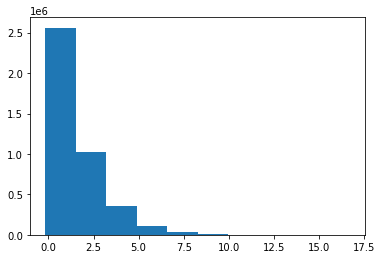

In [28]:
plt.hist(embeding_flatten.flatten().numpy())

In [15]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard


In [ ]:
%reload_ext tensorboard


In [17]:

%tensorboard --logdir="C:/Users/lavra/Documents/GitHub/painting-cracks/tensorboard_1000" 

Reusing TensorBoard on port 6006 (pid 9648), started 0:00:01 ago. (Use '!kill 9648' to kill it.)